# Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# YouTube data extraction

At first, I wanted to analyze all PS5 and Xbox tweets in September as many announcements occured that month (price, games, etc.). But it was too difficult for me to get the Twitter data. The API limitations only let me have access to the last 7 days of data. I also had a look at the scrapers (Twint, tweetscraper, GetOldTweets3, etc.) but they were all down for some reasons...
Therefore, I decided to change a bit the scope of the project.

I will have a look at the YouTube comments of both PS5 and Xbox games showcases.
The PS5 showcase occured on the 16th of September while the Xbox Series X showcase occured on the 23rd of July.

In [2]:
Xbox_data = pd.read_fwf('Xbox_comments.txt',header=None)

In [3]:
Xbox_data.fillna('',inplace=True)

In [4]:
#Consolidating text together in one column
Xbox_data['Text'] = Xbox_data[2]
Xbox_data.drop(2,axis=1,inplace=True)
for i in range(3,21):
    Xbox_data['Text']=Xbox_data['Text'] + " " + Xbox_data[i]
    Xbox_data.drop(i,axis=1,inplace=True)

In [5]:
#Removing ":" from end of column "1" (hours)
Xbox_data[1]=Xbox_data[1].apply(lambda x: x[:-1])

In [6]:
#Renaming columns
Xbox_data.rename(columns={0:'Date',1:'Hour'},inplace=True)

In [7]:
Xbox_data.tail()

,Date,Hour,Text
1148,2020-09-27,19:39:25,Pyschonauts looks mad
1149,2020-09-27,19:55:25,Cross fire looks incredible
1150,2020-09-28,10:49:45,What's the song at the end ?
1151,2020-09-29,06:05:50,why are people disliking this?
1152,2020-09-30,16:41:25,Imagine Fallout and Elder Scrolls with these g...


# Text processing

In [8]:
import nltk
import re

In [9]:
#Creating a function to clean the comments
def clean_text(text):
    text = re.sub(r'https?:\/\/\S+', '', text) #Removing hyperlinks
    text = re.sub(r"\d{2}:\d{2}s*", '', text) #Removing timestamps XX:XX
    text = re.sub(r"\d{1}:\d{2}s*", '', text) #Removing timestamps X:XX
    text = re.sub('[^A-Za-z0-9 ]+', '', text) #Removing special characters
    return text

In [10]:
Xbox_data['Text']=Xbox_data['Text'].apply(clean_text)

In [11]:
Xbox_data.head()

,Date,Hour,Text
0,2020-07-23,16:59:51,First
1,2020-07-23,16:59:55,bad
2,2020-07-23,16:59:56,First
3,2020-07-23,16:59:58,First comment
4,2020-07-23,17:00:02,Hello


# Tokenizer / Part-of-Speech tagging / Lemmatizer / Stop words removal

Below, a lot of steps are performed in one-go that I will explain in more details.
This website helped me a lot to understand this process:
https://www.machinelearningplus.com/nlp/lemmatization-examples-python/

My goal is to clean the comments so that words are standardized for the word clouds and sentiment analysis.

- First I tokenize the comments, this means that each word in a sentence is isolated 
          Example: "I ate these fruits." => [I, ate, these, fruits]
- Then, I perform part-of-speech (POS) tagging which goal is to classify isolated words by their type (nouns, verbs...) and add some context to the sentence
          Example: [I, ate, these, fruits] => [('I', 'PRP'), ('ate', 'VBP'), ('these', 'DT'), ('fruits', 'NNS')]
- Then, I lemmatize these words. That means that all words are brought back to their root form. The previous step helps the lemmatizer to perform better.
          Example: [('I', 'PRP'), ('ate', 'VBP'), ('these', 'DT'), ('fruits', 'NNS')] => [I, eat, these, fruit]
- Eventually, I remove all the stop words in order to keep only essential words in the sentence.
          Example: [I, eat, these, fruit] => [eat, fruit]

I also tried to implement a TextBlob spelling correction but it messed up with all game names... 'Tetris' became 'Debris', 'Fable' became 'Table'...

In [12]:
from nltk.corpus import wordnet
from nltk import pos_tag

def get_wordnet_pos(word):
    #Map POS tag to first character lemmatize() accepts
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

In [13]:
#We need to install the "stopwords" corpus in order to remove the stopwords
#nltk.download()

In [14]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 

lm = WordNetLemmatizer()

Xbox_data['Text clean'] = ""
for i in range(0,len(Xbox_data)):
    Xbox_data['Text clean'].loc[i] = [lm.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(Xbox_data['Text'].loc[i])]
    Xbox_data['Text clean'].loc[i] = [word for word in Xbox_data['Text clean'].loc[i] if word.lower() not in stopwords.words('english')]
    Xbox_data['Text clean'].loc[i] = " ".join(Xbox_data['Text clean'].loc[i])

In [15]:
Xbox_data.head()

,Date,Hour,Text,Text clean
0,2020-07-23,16:59:51,First,First
1,2020-07-23,16:59:55,bad,bad
2,2020-07-23,16:59:56,First,First
3,2020-07-23,16:59:58,First comment,First comment
4,2020-07-23,17:00:02,Hello,Hello


# Word cloud

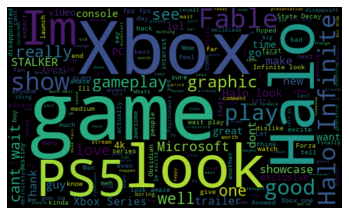

In [16]:
#Creating a word cloud
from wordcloud import WordCloud

full_text = ' '.join([txt for txt in Xbox_data['Text clean']])
wordcloud = WordCloud(width=500, height=300, max_font_size=119).generate(full_text)

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Sentiment Analysis

In this part, I will perform sentiment analysis to determine whether a comment is positive, neutral or negative.
I will use two different libraries: TextBlob and VADER.

I will perform the analysis on both "Text" and "Text clean" to see if the libraries perform better on the raw text or on the text with extra cleaning steps (POS, lemmatization, stop words removal etc.).
I will also try to determine the best library on this dataset.

These two articles helped me in this process:

https://towardsdatascience.com/sentiment-analysis-vader-or-textblob-ff25514ac540

https://medium.com/analytics-vidhya/textblob-the-nlp-preprocessing-godsend-1b404c35732e

#### *First approach: TextBlob*

In [17]:
from textblob import TextBlob

In [18]:
Xbox_data.head()

,Date,Hour,Text,Text clean
0,2020-07-23,16:59:51,First,First
1,2020-07-23,16:59:55,bad,bad
2,2020-07-23,16:59:56,First,First
3,2020-07-23,16:59:58,First comment,First comment
4,2020-07-23,17:00:02,Hello,Hello


In [19]:
def get_polarity(text):
    return TextBlob(text).sentiment.polarity

def get_subjectivity(text):
    return TextBlob(text).sentiment.subjectivity

In [20]:
Xbox_data['Polarity - TTB'] = Xbox_data['Text'].apply(get_polarity)
Xbox_data['Subjectivity - TTB'] = Xbox_data['Text'].apply(get_subjectivity)

Xbox_data['Polarity - TCTB'] = Xbox_data['Text clean'].apply(get_polarity)
Xbox_data['Subjectivity - TCTB'] = Xbox_data['Text clean'].apply(get_subjectivity)

In [21]:
Xbox_data.head()

,Date,Hour,Text,Text clean,Polarity - TTB,Subjectivity - TTB,Polarity - TCTB,Subjectivity - TCTB
0,2020-07-23,16:59:51,First,First,0.25,0.333333,0.25,0.333333
1,2020-07-23,16:59:55,bad,bad,-0.70,0.666667,-0.70,0.666667
2,2020-07-23,16:59:56,First,First,0.25,0.333333,0.25,0.333333
3,2020-07-23,16:59:58,First comment,First comment,0.25,0.333333,0.25,0.333333
4,2020-07-23,17:00:02,Hello,Hello,0.00,0.000000,0.00,0.000000


In [22]:
def sentiment_class(value):
    if value > 0:
        return "Positive"
    elif value == 0:
        return "Neutral"
    else:
        return "Negative"

In [23]:
Xbox_data['Sentiment - TTB'] = Xbox_data['Polarity - TTB'].apply(sentiment_class)
Xbox_data['Sentiment - TCTB'] = Xbox_data['Polarity - TCTB'].apply(sentiment_class)

In [24]:
Xbox_data['Sentiment - TTB'].value_counts()

Neutral     548
Positive    444
Negative    161
Name: Sentiment - TTB, dtype: int64

In [25]:
Xbox_data['Sentiment - TCTB'].value_counts()

Neutral     575
Positive    365
Negative    213
Name: Sentiment - TCTB, dtype: int64

In [26]:
print("{0:.0%}".format(len(Xbox_data[Xbox_data['Sentiment - TTB']=='Positive'])/len(Xbox_data)),'of positive comments with "Text".')
print("{0:.0%}".format(len(Xbox_data[Xbox_data['Sentiment - TTB']=='Neutral'])/len(Xbox_data)),'of neutral comments with "Text".')
print("{0:.0%}".format(len(Xbox_data[Xbox_data['Sentiment - TTB']=='Negative'])/len(Xbox_data)),'of negative comments with "Text".')

print("{0:.0%}".format(len(Xbox_data[Xbox_data['Sentiment - TCTB']=='Positive'])/len(Xbox_data)),'of positive comments with "Text clean".')
print("{0:.0%}".format(len(Xbox_data[Xbox_data['Sentiment - TCTB']=='Neutral'])/len(Xbox_data)),'of neutral comments with "Text clean".')
print("{0:.0%}".format(len(Xbox_data[Xbox_data['Sentiment - TCTB']=='Negative'])/len(Xbox_data)),'of negative comments with "Text clean".')

39% of positive comments with "Text".
48% of neutral comments with "Text".
14% of negative comments with "Text".
32% of positive comments with "Text clean".
50% of neutral comments with "Text clean".
18% of negative comments with "Text clean".


#### *Second approach: VADER*

In [27]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [28]:
sia = SentimentIntensityAnalyzer()

In [29]:
Xbox_data.head()

,Date,Hour,Text,Text clean,Polarity - TTB,Subjectivity - TTB,Polarity - TCTB,Subjectivity - TCTB,Sentiment - TTB,Sentiment - TCTB
0,2020-07-23,16:59:51,First,First,0.25,0.333333,0.25,0.333333,Positive,Positive
1,2020-07-23,16:59:55,bad,bad,-0.70,0.666667,-0.70,0.666667,Negative,Negative
2,2020-07-23,16:59:56,First,First,0.25,0.333333,0.25,0.333333,Positive,Positive
3,2020-07-23,16:59:58,First comment,First comment,0.25,0.333333,0.25,0.333333,Positive,Positive
4,2020-07-23,17:00:02,Hello,Hello,0.00,0.000000,0.00,0.000000,Neutral,Neutral


In [30]:
def get_sentiment(text):
    return sia.polarity_scores(text)

In [31]:
Xbox_data['Sentiment scores - TVD'] = Xbox_data['Text'].apply(get_sentiment)
Xbox_data['Sentiment scores - TCVD'] = Xbox_data['Text clean'].apply(get_sentiment)

In [32]:
Xbox_data.head()

,Date,Hour,Text,Text clean,Polarity - TTB,Subjectivity - TTB,Polarity - TCTB,Subjectivity - TCTB,Sentiment - TTB,Sentiment - TCTB,Sentiment scores - TVD,Sentiment scores - TCVD
0,2020-07-23,16:59:51,First,First,0.25,0.333333,0.25,0.333333,Positive,Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,2020-07-23,16:59:55,bad,bad,-0.70,0.666667,-0.70,0.666667,Negative,Negative,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound..."
2,2020-07-23,16:59:56,First,First,0.25,0.333333,0.25,0.333333,Positive,Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,2020-07-23,16:59:58,First comment,First comment,0.25,0.333333,0.25,0.333333,Positive,Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,2020-07-23,17:00:02,Hello,Hello,0.00,0.000000,0.00,0.000000,Neutral,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."


In [33]:
Xbox_data['Compound - TVD'] = Xbox_data['Sentiment scores - TVD'].apply(lambda score_dict: score_dict['compound'])
Xbox_data['Compound - TCVD'] = Xbox_data['Sentiment scores - TCVD'].apply(lambda score_dict: score_dict['compound'])

In [34]:
Xbox_data['Sentiment - TVD'] = Xbox_data['Compound - TVD'].apply(sentiment_class)
Xbox_data['Sentiment - TCVD'] = Xbox_data['Compound - TCVD'].apply(sentiment_class)

In [35]:
Xbox_data.head()

,Date,Hour,Text,Text clean,Polarity - TTB,Subjectivity - TTB,Polarity - TCTB,Subjectivity - TCTB,Sentiment - TTB,Sentiment - TCTB,Sentiment scores - TVD,Sentiment scores - TCVD,Compound - TVD,Compound - TCVD,Sentiment - TVD,Sentiment - TCVD
0,2020-07-23,16:59:51,First,First,0.25,0.333333,0.25,0.333333,Positive,Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000,Neutral,Neutral
1,2020-07-23,16:59:55,bad,bad,-0.70,0.666667,-0.70,0.666667,Negative,Negative,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...","{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",-0.5423,-0.5423,Negative,Negative
2,2020-07-23,16:59:56,First,First,0.25,0.333333,0.25,0.333333,Positive,Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000,Neutral,Neutral
3,2020-07-23,16:59:58,First comment,First comment,0.25,0.333333,0.25,0.333333,Positive,Positive,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000,Neutral,Neutral
4,2020-07-23,17:00:02,Hello,Hello,0.00,0.000000,0.00,0.000000,Neutral,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0.0000,Neutral,Neutral


#### *Comparison*

In [36]:
Xbox_data['Comparison T'] = ""

for i in range(0, len(Xbox_data)):
    if Xbox_data['Sentiment - TTB'].loc[i] == Xbox_data['Sentiment - TVD'].loc[i]:
        Xbox_data['Comparison T'].loc[i] = 1
    else:
        Xbox_data['Comparison T'].loc[i] = 0
        
        
Xbox_data['Comparison TC'] = ""

for i in range(0, len(Xbox_data)):
    if Xbox_data['Sentiment - TCTB'].loc[i] == Xbox_data['Sentiment - TCVD'].loc[i]:
        Xbox_data['Comparison TC'].loc[i] = 1
    else:
        Xbox_data['Comparison TC'].loc[i] = 0

/Users/salim/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [37]:
Xbox_data['Comparison T'].value_counts()

1    828
0    325
Name: Comparison T, dtype: int64

In [38]:
Xbox_data['Comparison TC'].value_counts()

1    772
0    381
Name: Comparison TC, dtype: int64

In [39]:
print("{0:.0%}".format(len(Xbox_data[Xbox_data['Comparison T']==1])/len(Xbox_data)),'of sentiment predictions are similar between TextBlob and VADER for "Text".')
print("{0:.0%}".format(len(Xbox_data[Xbox_data['Comparison T']==0])/len(Xbox_data)),'of sentiment predictions are different between TextBlob and VADER for "Text".')

print("{0:.0%}".format(len(Xbox_data[Xbox_data['Comparison TC']==1])/len(Xbox_data)),'of sentiment predictions are similar between TextBlob and VADER for "Text clean".')
print("{0:.0%}".format(len(Xbox_data[Xbox_data['Comparison TC']==0])/len(Xbox_data)),'of sentiment predictions are different between TextBlob and VADER for "Text clean".')

72% of sentiment predictions are similar between TextBlob and VADER for "Text".
28% of sentiment predictions are different between TextBlob and VADER for "Text".
67% of sentiment predictions are similar between TextBlob and VADER for "Text clean".
33% of sentiment predictions are different between TextBlob and VADER for "Text clean".


I see that 28% of sentiment predictions are different between the two libraries for 'Text'. My goal is to select the best predictor between the two. I will randomly choose 100 comments and assess manually which library has the right sentiment. The one which performed best will be the library I'll choose for my analysis. I will also assess whether to keep 'Text' or 'Text clean' for sentiment analysis.

For that, I will export the predictions and manually input the correct sentiment. Then calculate the accuracy for each case.

In [40]:
comparison = Xbox_data[Xbox_data['Comparison T']==0][['Text','Sentiment - TTB','Sentiment - TCTB','Sentiment - TVD','Sentiment - TCVD']].sample(100 ,random_state=42)
#comparison.to_csv('comparison_to_check.csv')

In [41]:
comparison_checked = pd.read_csv('comparison_checked.csv',sep=';')

In [42]:
comparison_checked

,Unnamed: 0,Text,Sentiment - TTB,Sentiment - TCTB,Sentiment - TVD,Sentiment - TCVD,True sentiment
0,834,the people who are complaining about halo grap...,Neutral,Neutral,Negative,Negative,Neutral
1,437,It was ok but Ill save my judgement until thes...,Neutral,Negative,Positive,Positive,Positive
2,881,Tell me why My thoughts exactly,Positive,Positive,Neutral,Neutral,Neutral
3,44,Nothing really interested me enough to switch ...,Positive,Positive,Negative,Negative,Negative
4,381,Well Im Soaked,Neutral,Neutral,Positive,Positive,Neutral
...,...,...,...,...,...,...,...
95,910,meh,Neutral,Neutral,Negative,Negative,Negative
96,227,Feel so sorry for Xbox players Maybe 5 years ...,Positive,Positive,Negative,Positive,Negative
97,1082,Original thought provoking moving and sometime...,Negative,Negative,Positive,Positive,Negative
98,513,bruh I knew they were lying about fable ...,Neutral,Neutral,Negative,Neutral,Negative


In [43]:
for j in ['Sentiment - TTB', 'Sentiment - TCTB', 'Sentiment - TVD', 'Sentiment - TCVD']:
    for i in range(0, len(comparison_checked)):
        if comparison_checked[j].loc[i] == comparison_checked['True sentiment'].loc[i]:
            comparison_checked[j].loc[i] = 1
        else:
            comparison_checked[j].loc[i] = 0

In [44]:
comparison_checked

,Unnamed: 0,Text,Sentiment - TTB,Sentiment - TCTB,Sentiment - TVD,Sentiment - TCVD,True sentiment
0,834,the people who are complaining about halo grap...,1,1,0,0,Neutral
1,437,It was ok but Ill save my judgement until thes...,0,0,1,1,Positive
2,881,Tell me why My thoughts exactly,0,0,1,1,Neutral
3,44,Nothing really interested me enough to switch ...,0,0,1,1,Negative
4,381,Well Im Soaked,1,1,0,0,Neutral
...,...,...,...,...,...,...,...
95,910,meh,0,0,1,1,Negative
96,227,Feel so sorry for Xbox players Maybe 5 years ...,0,0,1,0,Negative
97,1082,Original thought provoking moving and sometime...,1,1,0,0,Negative
98,513,bruh I knew they were lying about fable ...,0,0,1,0,Negative


In [45]:
print("{0:.0%}".format(sum(comparison_checked['Sentiment - TTB'])/len(comparison_checked)),'of sentiment predictions were correct for "Text" and TextBlob.')
print("{0:.0%}".format(sum(comparison_checked['Sentiment - TCTB'])/len(comparison_checked)),'of sentiment predictions were correct for "Text clean" and TextBlob.')
print("{0:.0%}".format(sum(comparison_checked['Sentiment - TVD'])/len(comparison_checked)),'of sentiment predictions were correct for "Text" and VADER.')
print("{0:.0%}".format(sum(comparison_checked['Sentiment - TCVD'])/len(comparison_checked)),'of sentiment predictions were correct for "Text clean" and VADER.')

30% of sentiment predictions were correct for "Text" and TextBlob.
33% of sentiment predictions were correct for "Text clean" and TextBlob.
55% of sentiment predictions were correct for "Text" and VADER.
50% of sentiment predictions were correct for "Text clean" and VADER.


Ok so we have interesting insights. It looks like VADER is way more efficient than TextBlob on this dataset.
Besides, this library performed better with the raw comments (i.e. without extra cleaning steps).

One could say 55% is a low accuracy but I am quite happy with that score knowing that these two libraries are not based on Machine Learning. They are mapping keywords with a fixed sentiment score. Moreover, YouTube comments are not the cleanest texts, people usually speak in a familiar way.

**Let's use VADER with the raw comments for our sentiment analysis.**

#### *Final sentiment analysis*

In [49]:
Xbox_data_sentiment = Xbox_data[['Date','Hour','Text','Sentiment - TVD']]

In [52]:
Xbox_data_sentiment['Sentiment - TVD'].value_counts()

Positive    469
Neutral     444
Negative    240
Name: Sentiment - TVD, dtype: int64

In [56]:
print("{0:.0%}".format(len(Xbox_data_sentiment[Xbox_data_sentiment['Sentiment - TVD']=='Positive'])/len(Xbox_data_sentiment)),'of Xbox YouTube comments are positive.')
print("{0:.0%}".format(len(Xbox_data_sentiment[Xbox_data_sentiment['Sentiment - TVD']=='Neutral'])/len(Xbox_data_sentiment)),'of Xbox YouTube comments are neutral.')
print("{0:.0%}".format(len(Xbox_data_sentiment[Xbox_data_sentiment['Sentiment - TVD']=='Negative'])/len(Xbox_data_sentiment)),'of Xbox YouTube comments are negative.')

41% of Xbox YouTube comments are positive.
39% of Xbox YouTube comments are neutral.
21% of Xbox YouTube comments are negative.


# Most discussed games

I need to create a list of the games featured at each showcase. Then isolate these games in the YouTube comments to determine which games were the most discussed by brand.